<a href="https://colab.research.google.com/github/sarath-githu/HAR_LSTM_COLAB/blob/master/Copy_of_skin_detection_derm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement ID 1344
### Al-based tool for preliminary diagnosis of Dermatological manifestations

The Global Burden of Disease project has shown that skin diseases continue to be the 4th leading cause of nonfatal disease burden worldwide. These conditions are often the presenting face of more severe systemic illnesses, including HIV and neglected tropical diseases (NTD). such as elephantiasis and other lymphedema-causing diseases. Additionally, skin disorders pose a significant threat to patients' well-being, mental health, ability to function, and social participation. However, it is very difficult to provide better dermatological care to under-served or resource-poor regions in a cost-effective manner owing to unavailability of efficient diagnostic tools, lack of connectivity, and poor laboratory infrastructure etc. Moreover, there is also a scarcity of physicians with dermatological training. Even, preliminary screening of a dermatological manifestation seems to be an arduous task. Thus, developing an Artificial intelligence-based tool (through Image processing technique) for preliminary diagnosis of numerous dermatological conditions will prove to be a boon in the health care system.

In [2]:
pip install opendatasets

In [3]:
pip install pandas

In [4]:
import opendatasets as od
import pandas
od.download("https://www.kaggle.com/datasets/shubhamgoel27/dermnet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kgsarathchandra
Your Kaggle Key: ··········


100%|██████████| 1.72G/1.72G [00:21<00:00, 86.9MB/s]


In [5]:
od.download("https://www.kaggle.com/datasets/mohamedabdalgwad/skindatasets")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kgsarathchandra
Your Kaggle Key: ··········


100%|██████████| 658M/658M [00:10<00:00, 63.3MB/s]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
import cv2
import os

from tensorflow.keras.preprocessing import image
# InceptionV3 is an image recognition model by GoogLeNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
# Base Libraries
from tensorflow.keras.applications import  VGG19,EfficientNetB0,VGG16,InceptionV3,ResNet50,EfficientNetB3
from tensorflow.keras.models import Model
# Transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
# Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [7]:
train2=os.listdir("/content/dermnet/train")

In [8]:
train2

['Hair Loss Photos Alopecia and other Hair Diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Nail Fungus and other Nail Disease',
 'Urticaria Hives',
 'Seborrheic Keratoses and other Benign Tumors',
 'Bullous Disease Photos',
 'Acne and Rosacea Photos',
 'Lupus and other Connective Tissue diseases',
 'Exanthems and Drug Eruptions',
 'Vascular Tumors',
 'Light Diseases and Disorders of Pigmentation',
 'Eczema Photos',
 'Systemic Disease',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Atopic Dermatitis Photos',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Herpes HPV and other STDs Photos',
 'Psoriasis pictures Lichen Planus and related diseases']

In [9]:
cat2=['Melanoma Skin Cancer Nevi and Moles']

In [10]:
cat=['Acne and Rosacea Photos',
 'Normal',
 'vitiligo',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
     'Melanoma Skin Cancer Nevi and Moles',
 'Eczema Photos']

In [11]:
def data_dictionary():
    path_train="/content/skindatasets/skin/train"
    path_test="/content/dermnet/train"
    list_train=cat
    list_train1=cat2
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+"/"+i
        image_list_train=os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j
            if img_path_train!="/content/skindatasets/skin/train/Normal/34.avif":

                train_dictionary["image_path"].append(img_path_train)
                train_dictionary['target'].append(k)
        k+=1
    for i in list_train1:
        path_disease_test=path_test+"/"+i
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train=path_disease_test+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(4)
    train_df=pd.DataFrame(train_dictionary)
    return  train_df

In [13]:
train=data_dictionary()

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  7330 non-null   object
 1   target      7330 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 114.7+ KB


In [53]:
import cv2
images=[]
label=[]
for i in train['image_path']:
    if i!="/content/skindatasets/skin/train/Normal/34.avif":
        img=cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(180,180))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img=cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA)
        #img=resize_and_rescale(img)
        images.append(img)


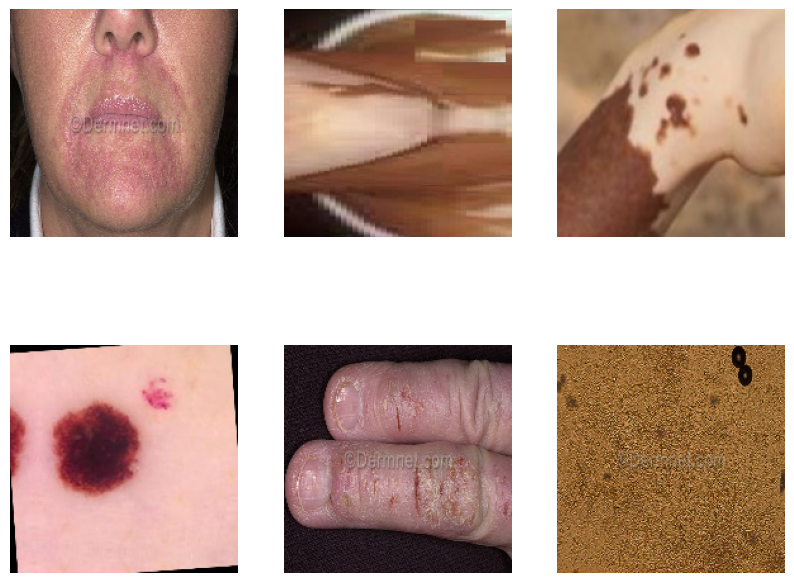

In [16]:
# Create a list of example inputs to our Gradio demo
example_list = [image for image in random.sample(images, k=6)]

# Plot the images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)
    ax.axis('off')

plt.show()


In [17]:
label=train['target']

In [18]:
len(label)

7330

In [19]:
len(images)

7330

In [20]:
import numpy as np
import pandas as pd

In [21]:
data=np.array(images)


In [22]:
label=np.array(label)

In [23]:
data.shape

(7330, 180, 180, 3)

In [24]:
label.shape

(7330,)

In [25]:
!pip install sklearn_relief

In [26]:
vgg_model = VGG19(weights = 'imagenet',  include_top = False, input_shape = (180, 180, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [27]:
# let's make all layers non-trainable
for layer in vgg_model.layers :
    layer.trainable = False

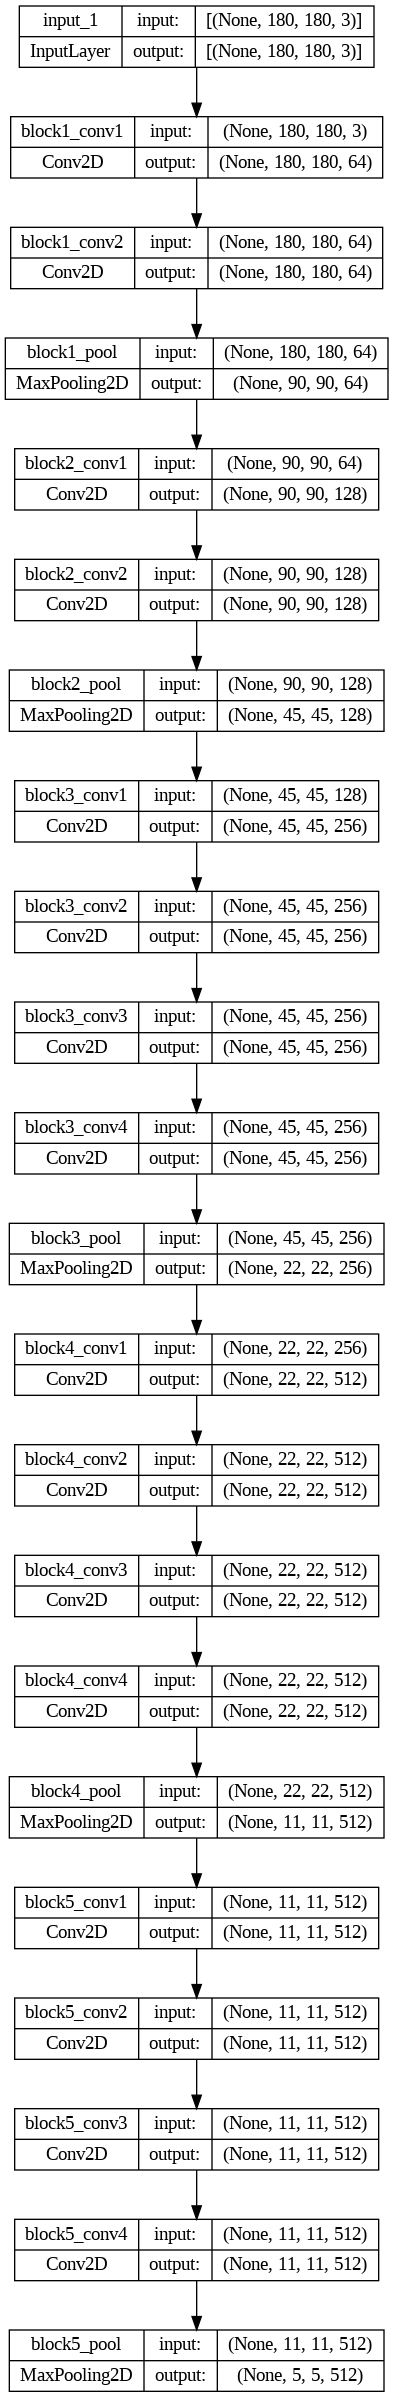

In [28]:
from keras.utils import plot_model
plot_model(vgg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense


In [30]:
model=Sequential([

                    Dense(200,activation='relu'),
                  Dense(170,activation='relu'),
                  Dense(6,activation='softmax'),

])

In [31]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [32]:
mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

In [33]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
kf = KFold(n_splits = 3)

In [35]:
import keras
acc=[]
num_classes = 6
label = keras.utils.to_categorical(label, num_classes)

In [36]:
label.shape


(7330, 6)

In [37]:

for i in range(3):
    x_train,x_test, y_train, y_test=train_test_split(data, label, test_size=0.2,random_state = np.random.randint(1,1000, 1)[0])
    print(x_train.shape)
    # let's make all layers non-trainable
    for layer in vgg_model.layers :
        layer.trainable = False
    features_train=vgg_model.predict(x_train)
    features_test=vgg_model.predict(x_test)
    print(features_train.shape)
    num_train=x_train.shape[0]
    num_test=x_test.shape[0]
    print(num_train)
    print(num_test)
    x_test=features_test.reshape(num_test,-1)
    x_train=features_train.reshape(num_train,-1)
    print(x_train.shape)
    print(x_train.shape)
    #x_train,x_valid,y_train,y_valid= train_test_split(x_train, y_train, test_size=0.1,random_state = np.random.randint(1,1000, 1)[0])
#     history=model.fit(x_train,y_train,epochs=15,batch_size=32,verbose=1)
#     model.evaluate(x_test,y_test)

(5864, 180, 180, 3)
46/46 [==============================] - 433s 9s/step
(5864, 5, 5, 512)
5864
1466
(5864, 12800)
(5864, 12800)
(5864, 180, 180, 3)
46/46 [==============================] - 427s 9s/step
(5864, 5, 5, 512)
5864
1466
(5864, 12800)
(5864, 12800)
(5864, 180, 180, 3)
46/46 [==============================] - 428s 9s/step
(5864, 5, 5, 512)
5864
1466
(5864, 12800)
(5864, 12800)


In [38]:
history = model.fit(x_train, y_train, epochs=25)


Epoch 1/25
184/184 [==============================] - 7s 29ms/step - loss: 1.7177 - accuracy: 0.7101
Epoch 2/25
184/184 [==============================] - 5s 26ms/step - loss: 0.5391 - accuracy: 0.8452
Epoch 3/25
184/184 [==============================] - 5s 25ms/step - loss: 0.3412 - accuracy: 0.9021
Epoch 4/25
184/184 [==============================] - 4s 23ms/step - loss: 0.2320 - accuracy: 0.9401
Epoch 5/25
184/184 [==============================] - 3s 16ms/step - loss: 0.1317 - accuracy: 0.9642
Epoch 6/25
184/184 [==============================] - 3s 16ms/step - loss: 0.0989 - accuracy: 0.9744
Epoch 7/25
184/184 [==============================] - 3s 19ms/step - loss: 0.1452 - accuracy: 0.9642
Epoch 8/25
184/184 [==============================] - 3s 16ms/step - loss: 0.1534 - accuracy: 0.9678
Epoch 9/25
184/184 [==============================] - 3s 16ms/step - loss: 0.2089 - accuracy: 0.9603
Epoch 10/25
184/184 [==============================] - 3s 17ms/step - loss: 0.1582 - accura

In [39]:
model.save('6claass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

In [41]:
y_pred=model.predict(x_test)

46/46 [==============================] - 0s 4ms/step


In [42]:
y_pred2=np.argmax(y_pred, axis=1)
y_pred2

array([0, 2, 5, ..., 0, 2, 1])

In [43]:
y_test=np.argmax(y_test, axis=1)

In [44]:
y_test

array([0, 2, 5, ..., 3, 2, 1])

In [45]:
confusion_matrix_result=confusion_matrix(y_test,y_pred2)

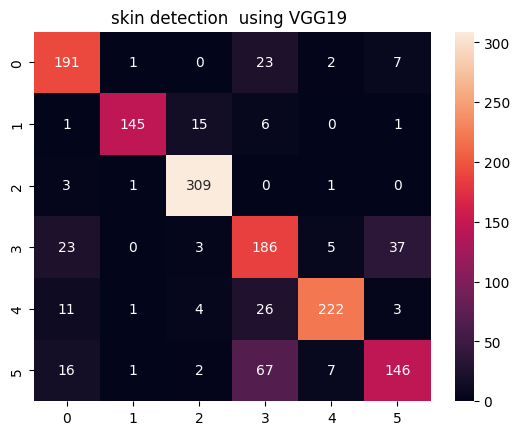

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
plt.title("skin detection  using VGG19 ")

ax= plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
pl.show()

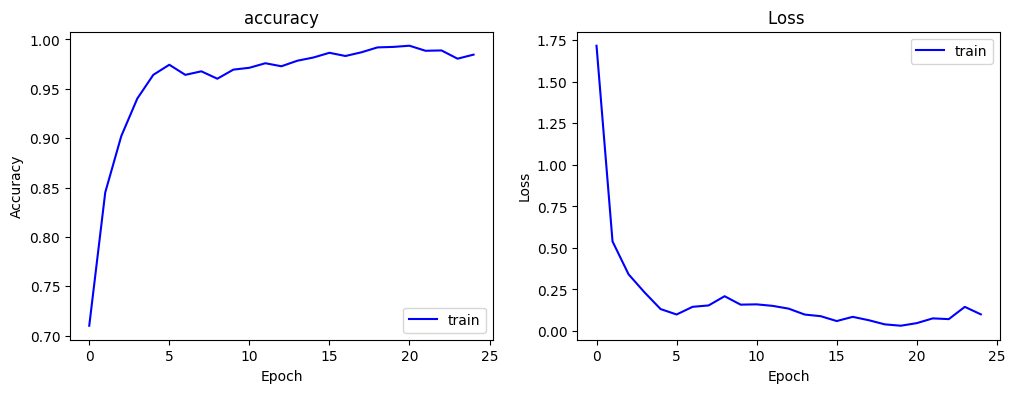

In [47]:
train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))
# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')

plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')

plt.title('Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [48]:
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D,MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image
import pandas as pd
import tensorflow as tf
import keras
import pickle

In [49]:
confusion_matrix=classification_report(y_test,y_pred2)

In [50]:
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       224
           1       0.97      0.86      0.91       168
           2       0.93      0.98      0.96       314
           3       0.60      0.73      0.66       254
           4       0.94      0.83      0.88       267
           5       0.75      0.61      0.67       239

    accuracy                           0.82      1466
   macro avg       0.83      0.81      0.82      1466
weighted avg       0.83      0.82      0.82      1466



In [56]:
import tensorflow as tf
import numpy as np
import cv2

import tensorflow as tf
import numpy as np
import cv2

def predict_skin_disease(image_path):
    # Load saved model
    model = tf.keras.models.load_model('6claass.h5')

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (180, 180))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    img=vgg_model.predict(img)
    img=img.reshape(1,-1)

    # Make prediction on preprocessed image
    pred = model.predict(img)[0]
    predicted_class = np.argmax(pred)

    return predicted_class


print(predict_skin_disease("/content/skindatasets/skin/test/Normal/0_0_aidai_0029.jpg"))

1/1 [==============================] - 0s 37ms/step
2


In [57]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [59]:
import tensorflow as tf
import numpy as np
import cv2

def predict_skin_disease(image_path):
    # Define list of class names
    class_names = ["Acne","Eczema","Atopic","Psoriasis","Tinea","vitiligo"]

    # Load saved model
    model = tf.keras.models.load_model('6claass.h5')

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (180, 180))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    img = vgg_model.predict(img)
    img = img.reshape(1, -1)

    # Make prediction on preprocessed image
    pred = model.predict(img)[0]
    predicted_class_index = np.argmax(pred)
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

print(predict_skin_disease("/content/dermnet/test/Atopic Dermatitis Photos/03ichthyosis050127.jpg"))


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 42ms/step
Atopic
